$\text{\textbf{\large Our beloved Dandelion}}$ <br>
$\text{\small HIMCM 2023}$ <br>


In [20]:
import numpy as np
import matplotlib.pyplot as plt

$\text{Distance Distribution}$ <br>
$\text{\footnotesize Written by Thitiwat Kosolpattanadurong}$ <br>
$\text{\footnotesize  The distribution of dandelion seed depends on many factors, such as the released height and wind speed and orientation.}$ <br>
$P(\boldsymbol{r}) = F(\textbf{V}, h_0)$
<br>
$\text{\footnotesize when } V \text{\footnotesize is the wind direction vector (This is based on the assumption that small area has a uniform distribution of wind)}$ <br> 
$\text{\footnotesize  Typically, the seeds will disperse in a range of 10 meters. However, there is a glimpse of chance that the seeds may travel}$ <br> $\text{\footnotesize very far from the source because of the turbulence so-called \textbf{Uplift}.}$
$\text{We assume that the journey of the seeds is not perfectly align with the wind, but it is governed with noise } \Delta \theta$. <br>
$\footnotesize \text{In the source code, } \theta_{\text{fluct}} = \frac{\Delta \theta}{\theta}$. <br><br> 
$\text{Updating procedure}$ <br>
$\text{\underline{Case 1}}$ $\text{Near-source Dispersal}$ <br>
$\text{Use Uniform Distribution (which is sucks)}$<br> <br>
$\text{\underline{Case 2}}$ $\text{Uplift } |V| > v_c$ <br>
$\footnotesize \text{Given the probability of uplifting is } p_u \text{. (This is subjected to the wind velocity) Normally, this is set at } p_u = 0.005$. <br>
$\footnotesize \text{According to the paper, the \textbf{log-log} graph of proportion of seeds and distance is linear.}$ <br>
$\footnotesize \text{We can guess that } P(D, D+\Delta D) = A e^{-\beta D} dD. \, D\geq10$

In [21]:
#case 2: long distance
#finding beta and proportional factor
#from the fact that p_10 -> inf = 0.05 and p_100 -> inf =  0.014
beta = np.log(0.05/0.014)/(100-10)
A = beta * np.exp(10*beta)
def P_long (d, A, beta):
    return A*np.exp(- beta*d) #Defining the probability density function (pdf)
print(A,beta)
def draw_long():
    A = 0.016293000449073537
    beta = 0.01414406306458764
    gamma = A*np.exp(-10*beta)
    return 10 - (1/beta) * np.log(1 - beta*np.random.random()/gamma) #drawing random value based on pdf
def destination(position, wind: np.ndarray(shape = (2,), dtype = float), uplift_prob: float, theta_fluct: float) -> np.ndarray(shape = (2,), dtype = float):
    #Normally uplift_prob should be set at 0.5% (0.005)
    #v fluct is the small variation of the wind orientation (delta theta/theta) (0 to 1)
    #orientation
    u_angle = np.angle(wind[0]+wind[1]*1j)*(1+theta_fluct*np.random.normal(0,1))
    u_v = np.array([np.cos(u_angle), np.sin(u_angle)])
    if (np.random.random() < uplift_prob):  #if uplift occurs
        destination = position + u_v *  draw_long()
    else:
        #dandelion terminal velocity 34.9 - 43 cm/s (It is very sensitive) from paper a separated vortex ring uniderlies ...
        vtmp = np.random.uniform(34.9,43)*0.01
        height = np.random.uniform(7.5,30)*0.01
        dest = position + u_v * np.random.uniform(0,10)
        #dest = position + (wind/(0.4*vtmp)) * (0.37*height + np.log(0.37*height/(np.e * 0.13*height)) + 0.13*height) #simple model
    return destination

0.016293000449073537 0.01414406306458764


$\text{Generate Probability Mask} \, \, P(D,\theta) = p_1(D) \cdot p_2 (\theta)$

In [22]:
def mask(position, wind, p_uplift, theta_fluct, N_sample,shape ):
    # Finding p_1 
    xx, yy = np.mgrid[:shape[0], :shape[1]]
    p_1_mask = np.zeros(shape)
    center = position
    for i in range(100):
        if (i < 10):
            p = (1-p_uplift)/10
        else: 
            p = p_uplift*A*np.exp(- beta*i)

        p_1_mask[np.logical_and((xx - center[0]) ** 2 + (yy - center[1]) ** 2 < (i+1)**2, (xx - center[0]) ** 2 + (yy - center[1]) ** 2 >= (i)**2)]+=p
    # Finding p_2 (theta)
    p_2_mask = np.zeros(shape)

    radius = max(shape[0],shape[1])
    x, y = np.ogrid[:shape[0], :shape[1]]
    distance = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    theta_0 = np.angle(wind[0]+wind[1]*1j)
    start_angle = theta_0*(1-theta_fluct) # Adjust the starting angle
    end_angle = theta_0*(1+theta_fluct)  # Adjust the ending angle
    # Create a mask for the sector
    sector_mask = np.logical_and(distance <= radius, np.logical_and(
        np.arctan2(y - center[1], x - center[0]) >= start_angle,
        np.arctan2(y - center[1], x - center[0]) <= end_angle
    ))
    p_2_mask[sector_mask] = 1
    p_final = p_1_mask*p_2_mask
    p_norm = (N_sample*p_final/(np.sum(p_final)+1e-9))
    
    return p_norm #This is a float

In [23]:
from scipy.stats import weibull_min

In [24]:
p_phoenix = [(1.95, 1.09),(2.91, 1.41),(2.76,	1.32),(2.62, 1.35)]
p_miami = [(4.66, 2.1),(5.02,2.34), (3.71, 1.86),(4.37,2.09)]
p_dayton = [(5.83, 2.16), (5.38, 1.88),(3.58, 1.66), (4.43, 1.67)]
D_phoenix = []
for D in range(4):
    D_phoenix += (weibull_min.rvs(p_phoenix[D][1], scale=p_phoenix[D][0], size=90)).tolist()
D_miami = []
for D in range(4):
    D_miami += (weibull_min.rvs(p_miami[D][1], scale=p_miami[D][0], size=90)).tolist()
D_dayton = []
for D in range(4):
    D_dayton += (weibull_min.rvs(p_dayton[D][1], scale=p_dayton[D][0], size=90)).tolist()

In [25]:
#including orientation
from scipy.stats import vonmises

In [26]:
R = D_dayton
THETA = vonmises(loc = 0, kappa = 0.7).rvs(360)
# Define the wind's vector
wind_velocity_list = [R[i]*np.array([np.sin(THETA[i]), np.cos(THETA[i])]) for i in range(len(R))]

In [27]:
file_path = "temp/temp_dayton.csv"
RAW_TEMP = np.genfromtxt(file_path, delimiter='\t')
temp_list = []
for i in range(12):
    temp_profile= RAW_TEMP[:,i]
    temp_profile_new = temp_profile[~np.isnan(temp_profile)]
    temp_list+=temp_profile_new.tolist()


In [28]:
#g(T) Temperature factor
def g_temp(T):
    T_min = 5.0
    T_opt = 15.0
    T_max = 35.0
    if (T < T_min):
        return 0
    elif (T_min <= T < T_opt):
        return (T-T_min)/(T_opt - T_min)
    else:
        return max((T_max-T)/(T_max-T_opt),0)

In [29]:
G_temp_list = [g_temp(temp_list[i]) for i in range(360)]

$\text{Main Code}$ <br>
$\text{\footnotesize Written by Tat Tangpirul}$

In [30]:
class Field():
    def __init__self():
        pass
    def initialize(self):
        self.rows = 100
        self.cols = 100
        # Create a matrix representing the number of Dandelions
        self.map = np.zeros((self.rows, self.cols), dtype = int)
        # Create a matrix representing the number of ready-to-eject-spore plants
        self.ready = np.zeros((run+5, self.rows,self.cols), dtype = int)
        # Create a matrix representing the number of dead plants
        self.dead = np.zeros((run+5,self.rows,self.cols), dtype = int)
        # Create a matrix representing the number of seedlings
        self.seedlings = np.zeros((run+5,self.rows,self.cols), dtype = int)
        # Create a matrix representing the number of seedlings
        self.flowering = np.zeros((run+5,self.rows,self.cols), dtype = int)

In [31]:
# Define timestep = 1 day
timestep = 1 
#Define grid_scale
grid_scale = 1 #1 grid = 1 x 1
# Define Runtime = 1 day (24 timesteps)
run = 359
# Assume that all dandelions take 3 days to germination, take 2 days to fertilize spore, and have a lifespan of 10 days
germination = 10
flowering = 78
fertilize = 12
reblooming = 179
lifespan = 500
n_spore = 252 #number of spores per plant
# Define carrying capacity
carrying_capacity = 87
temperature = 15

In [32]:
field = Field()
field.initialize()
# Allocate the first dandelion
field.map[49][49] = 1

field.ready[1][49][49] = 1
field.flowering[1][49][49] = 1
#field.dead[lifespan][0][0] = 1
for i in range(germination + flowering, min(lifespan,run), fertilize):
    field.ready[i][49][49] = 1
for i in range(run):
    print(field.ready[i][49][49], end=" ")

0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 

Possible Bugs
- The mask filter does not work for negative direction velocity
- เมื่อ dandelion ปล่อยสปอร์ครั้งเดียว สมมติให้ตายเลย (จะแก้ให้ไม่ตายก็ได้)
- ยังไม่ได้ใส่สมการปล่อยสปอร์ที่ขึ้นกับ velocity
- ยังไม่ได้ใส่ carrying capacity ทำให้เลขเยอะมากๆ (Grow exponentially)
- Index out of bounds ตอนรัน

In [33]:
#runing multiple times
N_iter = 100
N_dayton_map = []
N_dayton_flowering = []
N_dayton_seedling= []

In [34]:
for n in range(N_iter):
    print("________Iteration________", n+1)
    #Generate inital environment
    R = D_dayton
    THETA = vonmises(loc = 0, kappa = 0.7).rvs(360)
    # Define the wind's vector
    wind_velocity_list = [R[i]*np.array([np.sin(THETA[i]), np.cos(THETA[i])]) for i in range(len(R))]
    field = Field()
    field.initialize()
    # Allocate the first dandelion
    field.map[49][49] = 1

    field.ready[1][49][49] = 1
    field.flowering[1][49][49] = 1
    #field.dead[lifespan][0][0] = 1
    for i in range(germination + flowering, min(lifespan,run), fertilize):
        field.ready[i][49][49] = 1
    # Start simulating
    cur = 1 # current day
    n_plant_list = [] #store the list of #dandelions per timestep
    n_flowering_list = []  #store the list of #flowered per timestep
    n_seeding_list = [] #store the list of #seeds per timestep
    snapshot = [] #store the list of field.map per timestep
    # Look for the ready-to-eject-spore dendelion

    while(cur <= run):
        #generating carrying capacity
        carrying_capacity = 87
        #carrying_capacity = np.random.normal(87,18.878,size=(field.map.shape))
        #assign wind profile according to area
        angle = np.random.uniform(0, 2 * np.pi)  # Generate a random angle between 0 and 2*pi
        n_plant_list.append(np.sum(field.map.copy()))
        snapshot.append(field.map.copy())
        #for loop only non zero grid
        #initialize parameters before running simulation
        uplift_probability = 0.005 
        orientation_fluctuation = 0.1
        spore_total = np.zeros_like(field.map).astype(float) #for summing all spores released
        shape = (field.rows,field.cols)
        for i in range(field.rows):
            for j in range(field.cols): 
                if field.ready[cur][i][j] > 0:
                    # Calculate the destination of spores
                    n_germ = field.ready[cur][i][j] * n_spore
                    spore_total  += mask((i,j), wind_velocity_list[cur] , uplift_probability, orientation_fluctuation, n_germ,shape) #K = 100
        spore_add = G_temp_list[cur]*np.where(field.map.copy() + spore_total <= carrying_capacity, spore_total, carrying_capacity - field.map.copy())
        field.map += spore_add.astype(int) #add new spores
        
        if(cur + germination < run):
            for i in range(cur + germination, cur + germination + flowering + 1):
                if(i > run): break
                else: field.seedlings[i] += spore_add.astype(int)
            if(cur + germination + flowering <= run):
                field.flowering[cur + germination + flowering] += spore_add.astype(int) 

        # Set the ready date for old spores
        if(cur + reblooming < run):
            field.ready[cur + reblooming] += field.ready[cur]

        # Set the ready date for new spores
        if (cur + germination + flowering < run):
            field.ready[cur + germination + flowering] += spore_add.astype(int) #assign the seed dispersal status to all spores

        # Set the dead date for new spores
        if (cur + lifespan < run):
            field.dead[cur + lifespan] += spore_add.astype(int)
            
        field.map -= field.dead[cur]
        field.flowering[cur + 1] += field.flowering[cur]
        field.flowering[cur + 1] -= field.dead[cur]
        n_flowering_list.append(np.sum(field.flowering[cur].ravel()))
        n_seeding_list.append(np.sum(field.seedlings[cur].ravel()))
        print("Timestep",cur,n_plant_list[-1],end="\r")
        #print("Ready: ",np.sum(field.ready[cur].ravel()))
        #print("Added: ",np.sum(spore_add.ravel()))
        #print("Seedlings: ", np.sum(field.seedlings[cur].ravel()))
        #print("Flowering: ", np.sum(field.flowering[cur].ravel()))
        #print("Dead", np.sum(field.dead[cur].ravel()))
        #print('\n')
        cur += 1
    N_dayton_map.append(n_plant_list)
    N_dayton_flowering.append(n_flowering_list)
    N_dayton_seedling.append(n_seeding_list)
    print("TOTAL:",n_plant_list[-1],end = "\n")

________Iteration________ 1


TOTAL: 23357 23357
________Iteration________ 2
TOTAL: 48632 48632
________Iteration________ 3
TOTAL: 38446 38446
________Iteration________ 4
TOTAL: 40412 40412
________Iteration________ 5
TOTAL: 33648 33648
________Iteration________ 6
TOTAL: 47488 47488
________Iteration________ 7
TOTAL: 22144 22144
________Iteration________ 8
TOTAL: 29839 29839
________Iteration________ 9
TOTAL: 27901 27901
________Iteration________ 10
TOTAL: 28333 28333
________Iteration________ 11
TOTAL: 44183 44183
________Iteration________ 12
TOTAL: 33453 33453
________Iteration________ 13
TOTAL: 18862 18862
________Iteration________ 14
TOTAL: 42490 42490
________Iteration________ 15
TOTAL: 12000 12000
________Iteration________ 16
TOTAL: 21922 21922
________Iteration________ 17
TOTAL: 23409 23409
________Iteration________ 18
TOTAL: 38215 38215
________Iteration________ 19
TOTAL: 38151 38151
________Iteration________ 20
TOTAL: 18442 18442
________Iteration________ 21
TOTAL: 32263 32263
________Iteration________ 22


In [40]:
RESULT = np.array([i for i in N_dayton_map])
M = np.mean(RESULT,axis = 0)
S = np.std(RESULT,axis = 0)
n_miami_list = n_plant_list

In [41]:
for n,i in enumerate(M):
    print(M[n],S[n])

1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
69.96 49.08541942369443
69.96 49.08541942369443
69.96 49.08541942369443
69.96 49.08541942369443
69.96 49.08541942369443
69.96 49.08541942369443
69.96 49.08541942369443
69.96 49.08541942369443
69.96 49.08541942369443
69.96 49.08541942369443
69.96 49.08541942369443
69.96 49.08541942369443
208.87 9

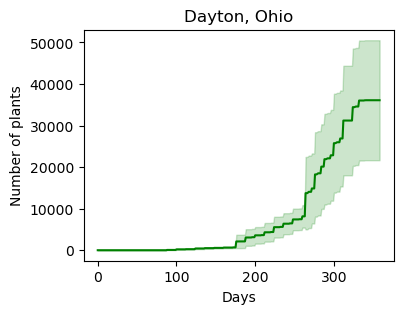

In [44]:
x = [i for i in range(len(M))]
y_mean = M
y_error = S
plt.figure(figsize=(4,3))
plt.plot(x,M,c='g')
#plt.errorbar(x, y_mean, yerr=y_error, fmt='o-', capsize=1)
plt.fill_between(x,(y_mean-y_error),(y_mean+y_error),alpha = 0.2,color='g')
# Adding labels and title
plt.xlabel('Days')
plt.ylabel('Number of plants')
plt.title('Dayton, Ohio')

# Display the plot
plt.show()


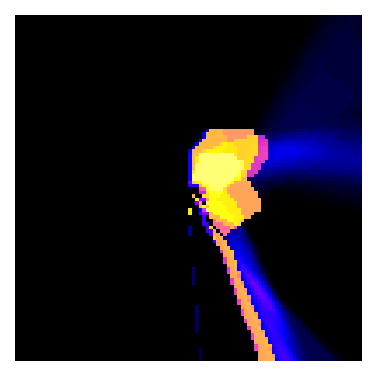

In [51]:
time = 358
PLOTTER = np.where(snapshot[time]>2*field.seedlings[time],2,1) * np.where(snapshot[time] > 0, 1, 0)
plt.figure(dpi = 150, figsize=(3,3))
plt.imshow(snapshot[time],cmap = 'gnuplot2')
#plt.colorbar(fraction=0.046, pad =0.04)
plt.axis("off")
plt.clim(0,90)

In [35]:
n_dayton_list = n_plant_list

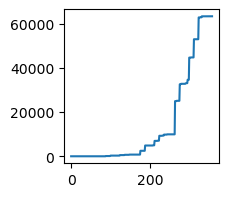

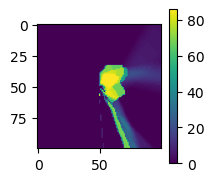

In [36]:
#Plot the number of plants
plt.figure(figsize=(2,2))
plt.plot(n_plant_list)
plt.figure(figsize=(2,2))
plt.imshow(snapshot[-1])
plt.colorbar()

$\text{Simulation Rendering}$ <br>
$\text{\footnotesize Required package:imageio}$

In [37]:
len(snapshot)

359

In [38]:
import imageio
fps = 120
imageio.mimsave('output.gif', snapshot, fps=fps)


Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 1]. Convert imag

Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 1]. Convert imag

In [39]:
'''
for k in range(n_germ):
                    des_row = np.random.randint(0,2) # Randomize the number between 0 and 1
                    des_col = np.random.randint(1, wind_velocity)
                    if (i + des_row < field.rows and j + des_col < field.cols):
                        #print('Destination: ', i + des_row, ' ', j + des_col)
                        field.map[i + des_row][j + des_col] += 1
                        field.ready[cur + germination][i + des_row][j + des_col] += 1
                        for l in range(cur + germination + fertilize, lifespan, fertilize):
                            field.ready[l][i + des_row][j + des_col] += 1 
                        if (cur + lifespan < run):
                            field.dead[cur + lifespan][i + des_row][j + des_col] += 1
                        else:
                            field.dead[run-1][i + des_row][j + des_col] += 1
                    else: pass #print("สปอร์หลุดแมพจ้า")
'''


'\nfor k in range(n_germ):\n                    des_row = np.random.randint(0,2) # Randomize the number between 0 and 1\n                    des_col = np.random.randint(1, wind_velocity)\n                    if (i + des_row < field.rows and j + des_col < field.cols):\n                        #print(\'Destination: \', i + des_row, \' \', j + des_col)\n                        field.map[i + des_row][j + des_col] += 1\n                        field.ready[cur + germination][i + des_row][j + des_col] += 1\n                        for l in range(cur + germination + fertilize, lifespan, fertilize):\n                            field.ready[l][i + des_row][j + des_col] += 1 \n                        if (cur + lifespan < run):\n                            field.dead[cur + lifespan][i + des_row][j + des_col] += 1\n                        else:\n                            field.dead[run-1][i + des_row][j + des_col] += 1\n                    else: pass #print("สปอร์หลุดแมพจ้า")\n'